# Код для обучения эмбеддингов и классификации

Цель: классификация стадии развития растения (культуры на полях) при известной культуре

Способ решения: так как на большое количество данных рассчитывать не приходится (есть много датасетов с распознанием болезней растений, но со стадиями развития культур - нет), будем использовать contrastive learning. В приложении изначально должна будет выбираться культура (или классифицироваться другой моделью поверх) и к предобученной MobileNetv3Small будет достраиваться необходимая для культуры голова. Каждая голова обучается отдельно и состоит из энкодера и классификатора. MobileNet не будем дообучать, чтобы не надо было копировать модель - это сэкономит очень много места. В итоге каждая отдельная голова из энкодера и классификатора весит около 10Кб, что позволяет масштабировать, добавляя в приложение всё новые и новые культуры практически не изменяя вес приложения.


Выберете культуру, для которой будет обучаться голова и загрузите архив с её фотографиями

необходимо загрузить в среду архив tar-формата. архитектура:

```
corn_only_tar.tar
└── corn_only/
    ├── 1-3 настоящих листа/
    │   ├── image_001.jpg
    │   ├── image_002.jpg
    │   ├── ...
    │   └── image_020.jpg
    │
    ├── 6-9 настоящих листьев/
    │   ├── image_001.jpg
    │   ├── image_002.jpg
    │   ├── ...
    │   └── image_020.jpg
    │
    ├── Восковая спелость/
    │   └── ...
    ├── Всходы/
    │   └── ...
    ├── Выбрасывание метёлки/
    │   └── ...
    ├── Молочная спелость/
    │   └── ...
    └── Молочно-восковая спелость/
        └── ...
```

Архитектура была протестирована на 20 картинках на класс, но чем их больше, тем лучше

Обязательно должно быть одинаковое количество картинок в каждом классе!!!

In [ ]:
!tar -xf soy_only_tar.tar

Обязательно замените константы при изменении условий задачи

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = "soy_only"
# количество стадий у культуры
N_CLASSES = 8
EMB_DIM = 16
BATCH_SIZE = 32
EPOCHS = 30

In [ ]:

import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torchvision.models as models
from torchvision import datasets


def get_train_transform():
    return transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.3, 0.3, 0.3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


def get_test_transform():
    return transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])


class SiameseDataset(Dataset):
    """
    Генерирует пары (img1, img2, target) на лету
    target = 1 → один класс
    target = 0 → разные классы
    """

    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = np.array(dataset.targets)
        self.label_set = np.unique(self.labels)
        self.label_to_indices = {
            label: np.where(self.labels == label)[0]
            for label in self.label_set
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, _):
        # случайный anchor
        idx1 = random.randint(0, len(self.dataset) - 1)
        img1, label1 = self.dataset[idx1]

        if random.random() < 0.5:
            # positive pair
            idx2 = idx1
            while idx2 == idx1:
                idx2 = random.choice(self.label_to_indices[label1])
            target = 1.0
        else:
            # negative pair
            neg_label = random.choice(list(self.label_set[self.label_set != label1]))
            idx2 = random.choice(self.label_to_indices[neg_label])
            target = 0.0

        img2, _ = self.dataset[idx2]
        return img1, img2, target


# архитектура нашего backbone. MobileNet_v3_Small (принимает на вход картинку 224*224),
# без классификационного слоя - будем использовать для извлечения фичей из картинки
# Не файнтюним, чтоб можно было использовать с любой головой, что сэкономит огромное количество памяти
# опционально можно попробовать файнтюн сразу со всеми головами, но скорее помешает, чем поможет
class MobileNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        net = models.mobilenet_v3_small(weights="DEFAULT")
        net.classifier = nn.Identity()
        self.backbone = net

    def forward(self, x):
        return self.backbone(x)


# Голова, создающаяся для каждой отдельной культуры. Здесь создается латентное пространство,
# создающее эмбеддинги, обучающиеся contrastive learning. После над ними надстроим классификатор
class EncoderHead(nn.Module):
    def __init__(self, in_dim=576, emb_dim=64):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, emb_dim)
        )

    def forward(self, features):
        return F.normalize(self.fc(features), dim=1)


# Вторая часть головы - надстроенный над обученным энкодером классификатор
class ClassifierHead(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, num_classes)
        )

    def forward(self, emb):
        return self.fc(emb)


# Сиамская сеть - собранная архитектура для contrastive learning
class SiameseNet(nn.Module):
    def __init__(self, backbone, encoder):
        super().__init__()
        self.backbone = backbone
        self.encoder = encoder

    def forward(self, x1, x2):
        f1 = self.backbone(x1)
        f2 = self.backbone(x2)
        z1 = self.encoder(f1)
        z2 = self.encoder(f2)
        return z1, z2


class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, z1, z2, target):
        dist = torch.norm(z1 - z2, dim=1)
        loss = target * dist.pow(2) + (1 - target) * torch.clamp(
            self.margin - dist, min=0
        ).pow(2)
        return loss.mean()

In [ ]:

# -------- DATA --------
train_ds = datasets.ImageFolder(
    DATA_DIR,
    transform=get_train_transform()
)
test_ds = datasets.ImageFolder(
    DATA_DIR,
    transform=get_test_transform()
)

siamese_train = SiameseDataset(train_ds)

train_loader = DataLoader(
    siamese_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

classifier_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)



# -------- MODEL --------
backbone = MobileNetBackbone()
embedding_net = EncoderHead(emb_dim=EMB_DIM).to(DEVICE)
for p in backbone.parameters():
  p.requires_grad=False

model = SiameseNet(backbone, embedding_net).to(DEVICE)

criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(
    embedding_net.fc.parameters(), lr=1e-3
)


# -------- TRAIN --------
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for img1, img2, target in train_loader:
        img1 = img1.to(DEVICE)
        img2 = img2.to(DEVICE)
        target = target.to(DEVICE)

        z1, z2 = model(img1, img2)
        loss = criterion(z1, z2, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/30 | Loss: 0.4755
Epoch 2/30 | Loss: 0.3314
Epoch 3/30 | Loss: 0.2232
Epoch 4/30 | Loss: 0.2238
Epoch 5/30 | Loss: 0.1924
Epoch 6/30 | Loss: 0.1685
Epoch 7/30 | Loss: 0.1843
Epoch 8/30 | Loss: 0.1942
Epoch 9/30 | Loss: 0.1931
Epoch 10/30 | Loss: 0.1917
Epoch 11/30 | Loss: 0.1772
Epoch 12/30 | Loss: 0.1548
Epoch 13/30 | Loss: 0.1482
Epoch 14/30 | Loss: 0.1511
Epoch 15/30 | Loss: 0.1491
Epoch 16/30 | Loss: 0.1554
Epoch 17/30 | Loss: 0.1472
Epoch 18/30 | Loss: 0.1383
Epoch 19/30 | Loss: 0.1366
Epoch 20/30 | Loss: 0.1447
Epoch 21/30 | Loss: 0.1353
Epoch 22/30 | Loss: 0.1325
Epoch 23/30 | Loss: 0.1295
Epoch 24/30 | Loss: 0.1214
Epoch 25/30 | Loss: 0.1293
Epoch 26/30 | Loss: 0.1423
Epoch 27/30 | Loss: 0.1306
Epoch 28/30 | Loss: 0.1426
Epoch 29/30 | Loss: 0.1155
Epoch 30/30 | Loss: 0.1284


In [ ]:
embedding_net.eval()
for p in embedding_net.parameters():
    p.requires_grad=False

classifier = ClassifierHead(EMB_DIM, N_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    classifier.train()
    total_loss = 0
    for images, labels in classifier_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.no_grad():
            features = backbone(images)
            emb = embedding_net(features)
        logits = classifier(emb)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(classifier_loader):.4f}")

Epoch 1/30 | Loss: 2.1214
Epoch 2/30 | Loss: 1.9291
Epoch 3/30 | Loss: 1.8834
Epoch 4/30 | Loss: 1.8672
Epoch 5/30 | Loss: 1.6640
Epoch 6/30 | Loss: 1.6719
Epoch 7/30 | Loss: 1.6533
Epoch 8/30 | Loss: 1.5760
Epoch 9/30 | Loss: 1.4328
Epoch 10/30 | Loss: 1.4957
Epoch 11/30 | Loss: 1.4200
Epoch 12/30 | Loss: 1.4639
Epoch 13/30 | Loss: 1.4282
Epoch 14/30 | Loss: 1.3707
Epoch 15/30 | Loss: 1.3976
Epoch 16/30 | Loss: 1.2997
Epoch 17/30 | Loss: 1.4237
Epoch 18/30 | Loss: 1.2773
Epoch 19/30 | Loss: 1.2417
Epoch 20/30 | Loss: 1.2057
Epoch 21/30 | Loss: 1.2121
Epoch 22/30 | Loss: 1.1925
Epoch 23/30 | Loss: 1.2503
Epoch 24/30 | Loss: 1.0391
Epoch 25/30 | Loss: 1.1568
Epoch 26/30 | Loss: 1.0764
Epoch 27/30 | Loss: 1.2055
Epoch 28/30 | Loss: 1.1359
Epoch 29/30 | Loss: 0.9705
Epoch 30/30 | Loss: 1.0562


In [ ]:
backbone.eval()
embedding_net.eval()
classifier.eval()

ClassifierHead(
  (fc): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [ ]:
import os
EXPORT_DIR = "export_soy"
os.makedirs(EXPORT_DIR, exist_ok=True)

In [ ]:
!pip install onnxscript onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00


## Не запускать, если MobileNet была скачана в файлы ранее

In [ ]:
# чистый backbone
backbone_export = MobileNetBackbone().to(DEVICE)
backbone_export.eval()

dummy_image = torch.randn(1, 3, 224, 224).to(DEVICE)

torch.onnx.export(
    backbone_export,
    dummy_image,
    f"{EXPORT_DIR}/mobilenet_backbone.onnx",
    input_names=["image"],
    output_names=["features"],
    opset_version=18,
    dynamic_axes={
        "image": {0: "batch"},
        "features": {0: "batch"}
    }
)

print("✅ backbone exported")


/tmp/ipython-input-856560188.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `MobileNetBackbone([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetBackbone([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 68 of general pattern rewrite rules.
✅ backbone exported


## Поменять пути и запустить для скачивания обученного энкодера и классификатора

In [ ]:
embedding_net.eval()
EMB_DIM = embedding_net.fc[-1].out_features
dummy_features = torch.randn(1, 576).to(DEVICE)

torch.onnx.export(
    embedding_net,
    dummy_features,
    f"{EXPORT_DIR}/encoder_soy.onnx",
    input_names=["features"],
    output_names=["embedding"],
    opset_version=18,
    dynamic_axes={
        "features": {0: "batch"},
        "embedding": {0: "batch"}
    }
)

print("✅ encoder_soy exported")

classifier.eval()
dummy_embedding = torch.randn(1, EMB_DIM).to(DEVICE)

torch.onnx.export(
    classifier,
    dummy_embedding,
    f"{EXPORT_DIR}/classifier_soy.onnx",
    input_names=["embedding"],
    output_names=["logits"],
    opset_version=18,
    dynamic_axes={
        "embedding": {0: "batch"},
        "logits": {0: "batch"}
    }
)

print("✅ classifier_soy exported")


/tmp/ipython-input-795266582.py:5: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `EncoderHead([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EncoderHead([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 2 of general pattern rewrite rules.
✅ encoder_soy exported


/tmp/ipython-input-795266582.py:23: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `ClassifierHead([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ClassifierHead([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 2 of general pattern rewrite rules.
✅ classifier_soy exported


In [ ]:
import json

meta = {
    "culture": "soy",
    "backbone": "mobilenet_v3_small",
    "feature_dim": 576,
    "embedding_dim": EMB_DIM,
    "num_classes": len(train_ds.classes),
    "class_names": train_ds.classes,
    "onnx": {
        "backbone": "mobilenet_backbone.onnx",
        "encoder": "encoder_soy.onnx",
        "classifier": "classifier_soy.onnx"
    }
}

with open(f"{EXPORT_DIR}/meta_soy.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print("✅ meta_soy.json saved")


✅ meta_soy.json saved


In [ ]:
!zip -r export_soy_dir.zip export_soy

  adding: export_soy/ (stored 0%)
  adding: export_soy/encoder_soy.onnx (deflated 74%)
  adding: export_soy/encoder_soy.onnx.data (deflated 8%)
  adding: export_soy/classifier_soy.onnx.data (deflated 6%)
  adding: export_soy/classifier_soy.onnx (deflated 73%)
  adding: export_soy/meta_soy.json (deflated 46%)


# Тестирование

/tmp/ipython-input-1972946567.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap_name, N_CLASSES)


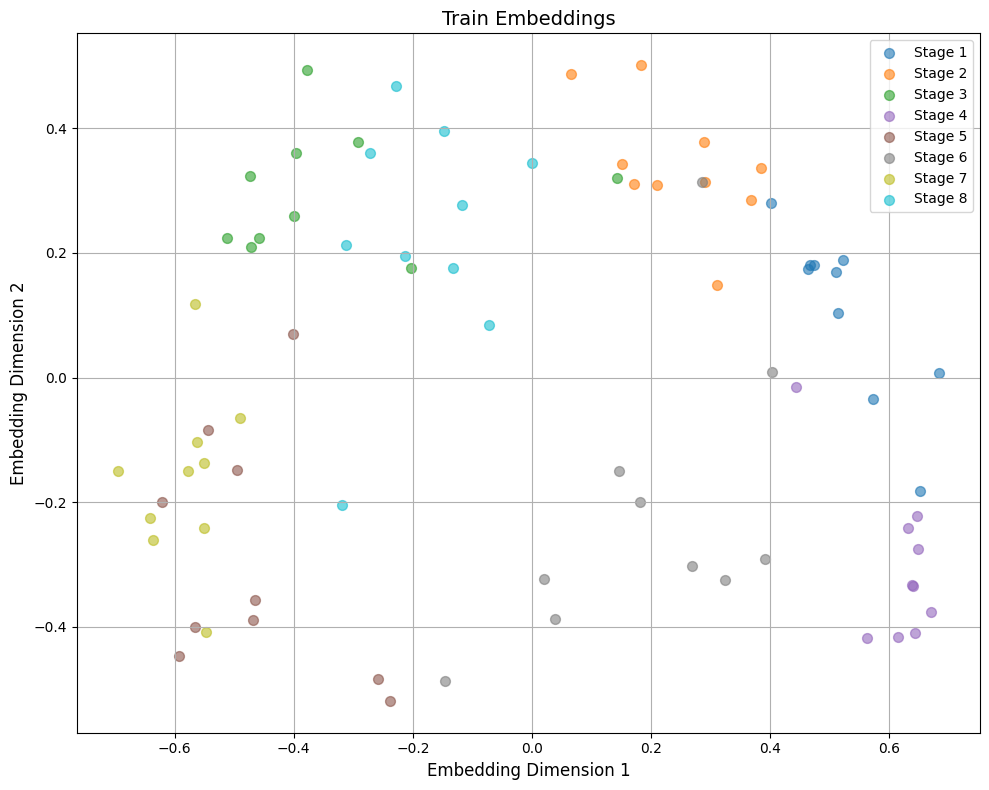

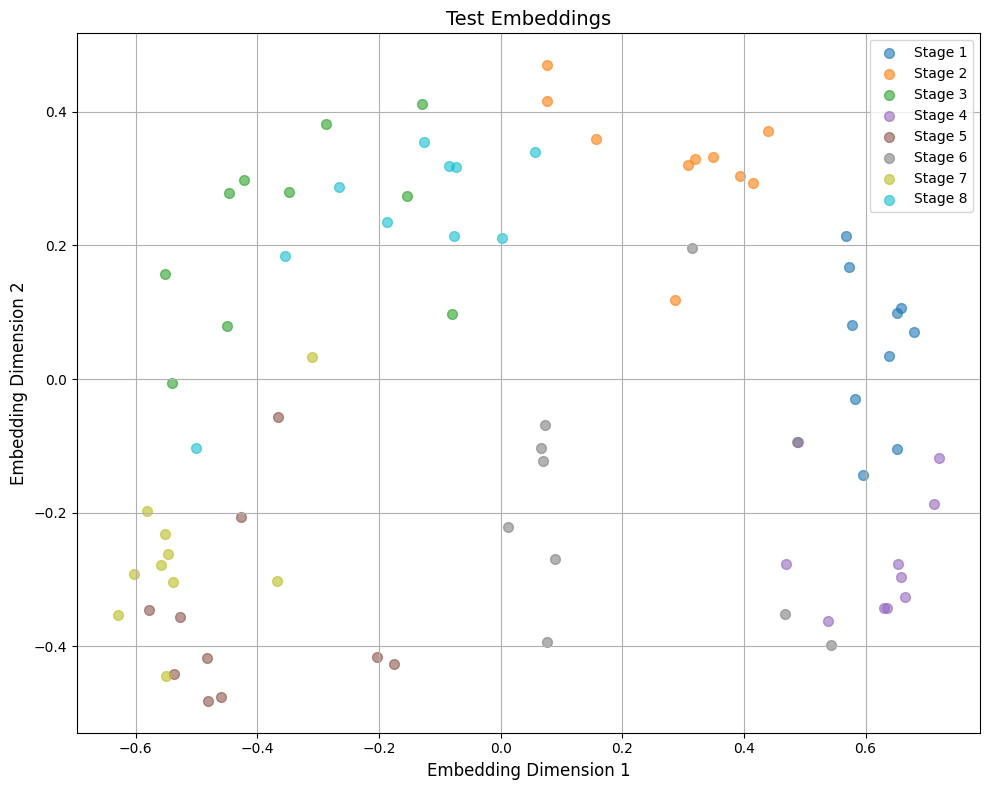

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def extract_embeddings(backbone, encoder, dataloader, device, max_samples=1000):
    backbone.eval()
    encoder.eval()

    embeddings = []
    labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)

            feats = backbone(images)
            emb = encoder(feats)

            embeddings.append(emb.cpu().numpy())
            labels.append(targets.numpy())

            if len(np.concatenate(labels)) >= max_samples:
                break

    embeddings = np.concatenate(embeddings)[:max_samples]
    labels = np.concatenate(labels)[:max_samples]
    return embeddings, labels

import umap
def extract_and_reduce_embeddings(backbone, encoder, dataloader, emb_dim, method='umap', reducer=None, is_train=True, device='cuda'):
    embeddings, labels = extract_embeddings(backbone, encoder, dataloader, device)
    if reducer is None and is_train:
        if method=='umap':
            reducer = umap.UMAP(n_components=2, random_state=42)
        elif method=='pca':
            reducer = PCA(n_components=2, random_state=42)
        emb_2d = reducer.fit_transform(embeddings)

    elif reducer is not None and not is_train:
        emb_2d = reducer.transform(embeddings)

    return emb_2d, labels, reducer

import matplotlib.cm as cm

def plot_corn_embeddings(embeddings, targets, title="Corn Embeddings", cmap_name="tab10"):
    """Визуализация эмбеддингов для кукурузы"""
    plt.figure(figsize=(10, 8))

    colors = cm.get_cmap(cmap_name, N_CLASSES)
    class_names = [f"Stage {i+1}" for i in range(N_CLASSES)]

    for i in range(N_CLASSES):
        inds = np.where(targets == i)[0]
        if len(inds) > 0:
            plt.scatter(embeddings[inds, 0], embeddings[inds, 1],
                       alpha=0.6, color=colors(i), label=class_names[i], s=50)

    plt.title(title, fontsize=14)
    plt.xlabel("Embedding Dimension 1", fontsize=12)
    plt.ylabel("Embedding Dimension 2", fontsize=12)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


test_loader = DataLoader(test_ds)

train_embeddings, train_labels, reducer = extract_and_reduce_embeddings(backbone, embedding_net, classifier_loader, EMB_DIM, method='pca')
test_embeddings, test_labels, _ = extract_and_reduce_embeddings(backbone, embedding_net, test_loader, EMB_DIM, reducer=reducer, is_train=False, method='pca')
plot_corn_embeddings(train_embeddings, train_labels, "Train Embeddings")
plot_corn_embeddings(test_embeddings, test_labels, "Test Embeddings")


In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)

def evaluate_classifier(
    backbone,
    encoder,
    classifier,
    dataloader,
    device,
    class_names=None,
    verbose=True
):
    backbone.eval()
    encoder.eval()
    classifier.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            feats = backbone(images)
            emb = encoder(feats)
            logits = classifier(emb)

            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    # ---------- Overall accuracy ----------
    acc = accuracy_score(y_true, y_pred)

    if verbose:
        print("=" * 60)
        print(f"Overall accuracy: {acc * 100:.2f}%")
        print("=" * 60)

        # ---------- Classification report ----------
        print("\nClassification report:")
        print(
            classification_report(
                y_true,
                y_pred,
                target_names=class_names,
                digits=3
            )
        )

        # ---------- Confusion matrix ----------
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion matrix (rows = true, cols = pred):")
        print(cm)

        # ---------- Per-class error analysis ----------
        print("\nPer-class error analysis:")
        num_classes = cm.shape[0]

        for i in range(num_classes):
            total = cm[i].sum()
            correct = cm[i, i]
            wrong = total - correct

            class_name = class_names[i] if class_names else f"Class {i}"
            acc_i = correct / total if total > 0 else 0.0

            print(
                f"  {class_name}: "
                f"{correct}/{total} correct "
                f"({acc_i * 100:.1f}% acc, {wrong} errors)"
            )

            # Top confusions
            confusions = cm[i].copy()
            confusions[i] = 0
            top_mistakes = np.argsort(confusions)[::-1]

            for j in top_mistakes:
                if confusions[j] > 0:
                    other_name = (
                        class_names[j] if class_names else f"Class {j}"
                    )
                    print(
                        f"    ↳ confused with {other_name}: "
                        f"{confusions[j]} times"
                    )
                    break

    return acc, y_true, y_pred


acc, y_true, y_pred = evaluate_classifier(
    backbone,
    embedding_net,
    classifier,
    classifier_loader,
    DEVICE, class_names=train_ds.classes
)

acc, y_true, y_pred = evaluate_classifier(
    backbone,
    embedding_net,
    classifier,
    test_loader,
    DEVICE, class_names=test_ds.classes
)

Overall accuracy: 86.25%

Classification report:
                       precision    recall  f1-score   support

  1-3 тройчатых листа      0.818     0.900     0.857        10
3-5 тройчатых листьев      0.714     1.000     0.833        10
          Бутонизация      0.900     0.900     0.900        10
               Всходы      1.000     0.900     0.947        10
          Налив семян      0.818     0.900     0.857        10
     Созревание семян      1.000     0.800     0.889        10
   Формирование бобов      0.800     0.800     0.800        10
             Цветение      1.000     0.700     0.824        10

             accuracy                          0.863        80
            macro avg      0.881     0.863     0.863        80
         weighted avg      0.881     0.863     0.863        80

Confusion matrix (rows = true, cols = pred):
[[ 9  1  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  1  0]
 [ 1  0  0  9  0  0  0  0]
 [ 0  0  0  0  9  0  1  0]
 [ 1  1  0  

In [ ]:
idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
print(idx_to_class)

{0: '1-3 тройчатых листа', 1: '3-5 тройчатых листьев', 2: 'Бутонизация', 3: 'Всходы', 4: 'Налив семян', 5: 'Созревание семян', 6: 'Формирование бобов', 7: 'Цветение'}


Для картинки вообще другого растения выдает неуверенные предсказания, значит всё хорошо

In [ ]:
image_path = 'Screenshot 2025-12-13 180301.png'
transform = get_test_transform()

    # Загрузка и преобразование изображения
image = Image.open(image_path).convert('RGB')
image_tensor = transform(image).unsqueeze(0).to(DEVICE)  # [1, 3, 224, 224]

with torch.no_grad():
        features = backbone(image_tensor)
        embeds = embedding_net(features)
        probabilities = classifier(embeds)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Преобразуем в numpy для удобства
probabilities = torch.softmax(probabilities.squeeze().cpu(), dim=0).numpy()


print(f"Предсказанная фаза: {idx_to_class[predicted_class]}\n")
for i, prob in enumerate(probabilities):
  print(f'{idx_to_class[i]}: {prob}')

Предсказанная фаза: Бутонизация

1-3 тройчатых листа: 0.0303939338773489
3-5 тройчатых листьев: 0.05091146379709244
Бутонизация: 0.4213203489780426
Всходы: 0.045555904507637024
Налив семян: 0.11771558225154877
Созревание семян: 0.028553249314427376
Формирование бобов: 0.23600313067436218
Цветение: 0.06954637169837952
